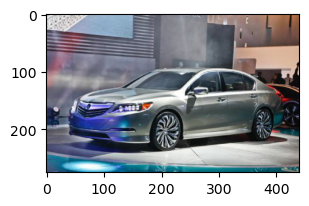

In [1]:
import paddle
import os
import paddle.vision
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# 定义展示图片函数
def show_images(imgs_paths=[],cols=4):
    num_samples = len(imgs_paths)
    plt.figure(figsize=(15,15))
    i = 0
    for img_path in imgs_paths:
        img = Image.open(img_path)Utility_Knife
        plt.subplot(int(num_samples/cols + 1), cols, i + 1)
        plt.imshow(img)
        i += 1
imgs_paths = [
    "work/cars/cars_train/05930.jpg"
]
show_images(imgs_paths)

In [2]:
# 构建数据集
import os
import paddle
import paddle.nn as nn
import paddle.vision as V
from PIL import Image
from matplotlib import pyplot as plt
from paddle.io import DataLoader

# 这里我们不需要用到图像标签，可以直接用paddle.vision里面提供的数据集接口
def get_data(args):
    transforms = V.transforms.Compose([
        V.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        V.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        V.transforms.ToTensor(),
        V.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = V.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

In [3]:
"""ddpm"""

import os
import paddle
import paddle.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from paddle import optimizer
# from utils import *
from modules import UNet    # 模型
import logging
import numpy as np

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

100%|█████████████████████████████████████████████████████████████████████| 204/204 [00:19<00:00, 10.28it/s, MSE=0.253]
499it [00:13, 36.17it/s]


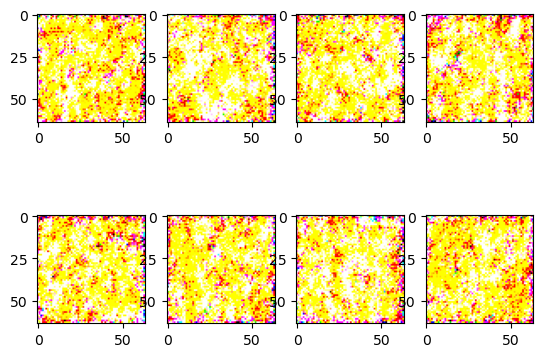

100%|████████████████████████████████████████████████████████████████████| 204/204 [00:18<00:00, 10.78it/s, MSE=0.0281]
499it [00:13, 37.80it/s]


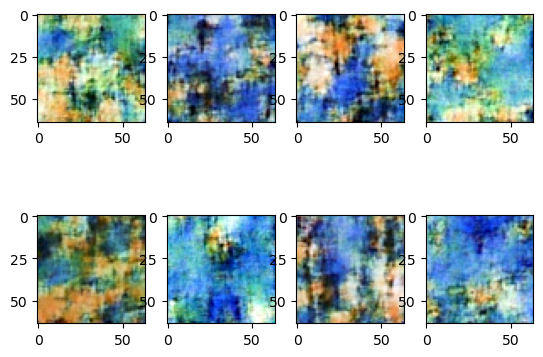

100%|████████████████████████████████████████████████████████████████████| 204/204 [00:18<00:00, 10.90it/s, MSE=0.0307]
499it [00:13, 37.74it/s]


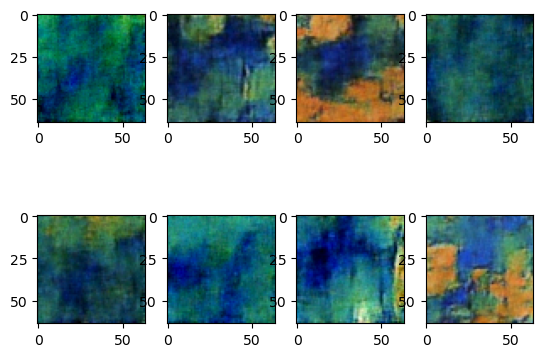

 92%|███████████████████████████████████████████████████████████████▌     | 188/204 [00:17<00:01, 10.58it/s, MSE=0.042]


KeyboardInterrupt: 

In [7]:
class Diffusion:
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule()
        self.alpha = 1. - self.beta
        self.alpha_hat = paddle.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return paddle.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = paddle.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = paddle.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = paddle.randn(shape=x.shape)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return paddle.randint(low=1, high=self.noise_steps, shape=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with paddle.no_grad():
            x = paddle.randn((n, 3, self.img_size, self.img_size))
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):


                t = paddle.to_tensor([i] * x.shape[0]).astype("int64")
                # print(x.shape, t.shape)

                # print(f"完成第{i}步")
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = paddle.randn(shape=x.shape)
                else:
                    noise = paddle.zeros_like(x)
                x = 1 / paddle.sqrt(alpha) * (x - ((1 - alpha) / (paddle.sqrt(1 - alpha_hat))) * predicted_noise) + paddle.sqrt(beta) * noise
        model.train()
        x = (x.clip(-1, 1) + 1) / 2
        x = (x * 255)
        return x

def train(args):
    # setup_logging(args.run_name)
    device = args.device
    dataloader = get_data(args)

    image = next(iter(dataloader))[0]

    model = UNet()
    opt = optimizer.Adam(learning_rate=args.lr, parameters=model.parameters())
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    # logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, images in enumerate(pbar):
            # print(images)
            t = diffusion.sample_timesteps(images[0].shape[0])
            x_t, noise = diffusion.noise_images(images[0], t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)  # 损失函数

            opt.clear_grad()
            loss.backward()
            opt.step()

            pbar.set_postfix(MSE=loss.item())

            # print(("MSE", loss.item(), "global_step", epoch * l + i))
            # logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        
        if epoch % 20 == 0:
            # paddle.save(model.state_dict(), f"car_models/ddpm_uncond{epoch}.pdparams")
            paddle.save(model.state_dict(), f"xray_models/ddpm_uncond{epoch}.pdparams")
            sampled_images = diffusion.sample(model, n=8)

            for i in range(8):
                img = sampled_images[i].transpose([1, 2, 0])
                img = np.array(img).astype("uint8")
                plt.subplot(2,4,i+1)
                plt.imshow(img)
            plt.show()

def launch():
    import argparse

    # 参数设置
    class ARGS:
        def __init__(self):
            self.run_name = "DDPM_Uncondtional"
            self.epochs = 800
            self.batch_size = 8
            self.image_size = 64
            #self.dataset_path = r"work/cars"
            self.dataset_path = r"work/OPIXray/train/train_crop/Utility_Knife"
            
            self.device = "cuda"
            self.lr = 1.5e-4

    args = ARGS()
    train(args)


if __name__ == '__main__':
    launch()
    pass

In [ ]:
# 使用训练好的模型进行采样
import paddle

model = UNet()
model.set_state_dict(paddle.load("car_models/ddpm_uncond640.pdparams"))   # 加载模型文件
diffusion = Diffusion(img_size=64, device="cuda")

sampled_images = diffusion.sample(model, n=8)

# 采样图片
for i in range(8):
    img = sampled_images[i].transpose([1, 2, 0])
    img = np.array(img).astype("uint8")
    plt.subplot(2, 4,i+1)
    plt.imshow(img)
plt.show()

In [ ]:
# 加载数据集
"""由于条件生成需要同时提供图片标签，因此我们这里自定义数据集"""

# 1、将图片数据写入txt文件。flowers本来是分类数据集，这里我们把他的训练集和验证集都提取出来，当作我们生成模型的训练集。
import os
train_sunflower = os.listdir("work/flowers/pic/train/sunflower")            # 0——向日葵
valid_sunflower = os.listdir("work/flowers/pic/validation/sunflower")       # 0——向日葵
train_rose      = os.listdir("work/flowers/pic/train/rose")                 # 1——玫瑰
valid_rose      = os.listdir("work/flowers/pic/validation/rose")            # 1——玫瑰
train_tulip     = os.listdir("work/flowers/pic/train/tulip")                # 2——郁金香
valid_tulip     = os.listdir("work/flowers/pic/validation/tulip")           # 2——郁金香
train_dandelion = os.listdir("work/flowers/pic/train/dandelion")            # 3——蒲公英
valid_dandelion = os.listdir("work/flowers/pic/validation/dandelion")       # 3——蒲公英
train_daisy     = os.listdir("work/flowers/pic/train/daisy")                # 4——雏菊
valid_daisy     = os.listdir("work/flowers/pic/validation/daisy")           # 4——雏菊

with open("flowers_data.txt", 'w') as f:
    for image in train_sunflower:
        f.write("work/flowers/pic/train/sunflower/" + image + ";" + "0" + "\n")
    for image in valid_sunflower:
        f.write("work/flowers/pic/validation/sunflower/" + image + ";" + "0" + "\n")
    for image in train_rose:
        f.write("work/flowers/pic/train/rose/" + image + ";" + "1" + "\n")
    for image in valid_rose:
        f.write("work/flowers/pic/validation/rose/" + image + ";" + "1" + "\n")
    for image in train_tulip:
        f.write("work/flowers/pic/train/tulip/" + image + ";" + "2" + "\n")
    for image in valid_tulip:
        f.write("work/flowers/pic/validation/tulip/" + image + ";" + "2" + "\n")
    for image in train_dandelion:
        f.write("work/flowers/pic/train/dandelion/" + image + ";" + "3" + "\n")
    for image in valid_dandelion:
        f.write("work/flowers/pic/validation/dandelion/" + image + ";" + "3" + "\n")
    for image in train_daisy:
        f.write("work/flowers/pic/train/daisy/" + image + ";" + "4" + "\n")
    for image in valid_daisy:
        f.write("work/flowers/pic/validation/daisy/" + image + ";" + "4" + "\n")

In [ ]:
# 2、构建数据集
# 数据变化，返回图片与标签
import paddle.vision as V
from PIL import Image
from paddle.io import Dataset, DataLoader
from tqdm import tqdm

# 数据变换
transforms = V.transforms.Compose([
        V.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        V.transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
        V.transforms.ToTensor(),
        V.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

class TrainDataFlowers(Dataset):
    def __init__(self, txt_path="flowers_data.txt"):
        with open(txt_path, "r") as f:
            data = f.readlines()
        self.image_paths = data[:-1]    # 最后一行是空行，舍弃
    
    def __getitem__(self, index):
        image_path, label = self.image_paths[index].split(";")
        image = Image.open(image_path)
        image = transforms(image)

        label = int(label)
        
        return image, label
    
    def __len__(self):
        return len(self.image_paths)

dataset = TrainDataFlowers()
dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

if __name__ == "__main__": # 测试数据集是否可用
    pbar = tqdm(dataloader)
    for i, (images, labels) in enumerate(pbar):
        pass
    print("ok")

In [ ]:
import os
import paddle
import copy
import paddle.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from paddle import optimizer
from modules import UNet_conditional, EMA
import logging
import numpy as np
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

class Diffusion:
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule()
        self.alpha = 1. - self.beta
        self.alpha_hat = paddle.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return paddle.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = paddle.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = paddle.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = paddle.randn(shape=x.shape)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return paddle.randint(low=1, high=self.noise_steps, shape=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with paddle.no_grad():
            x = paddle.randn((n, 3, self.img_size, self.img_size))
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = paddle.to_tensor([i] * x.shape[0]).astype("int64")
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    cfg_scale = paddle.to_tensor(cfg_scale).astype("float32")
                    predicted_noise = paddle.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = paddle.randn(shape=x.shape)
                else:
                    noise = paddle.zeros_like(x)
                x = 1 / paddle.sqrt(alpha) * (x - ((1 - alpha) / (paddle.sqrt(1 - alpha_hat))) * predicted_noise) + paddle.sqrt(beta) * noise
        model.train()
        x = (x.clip(-1, 1) + 1) / 2
        x = (x * 255)
        return x


def train(args):
    # setup_logging(args.run_name)
    device = args.device
    dataloader = args.dataloader
    model = UNet_conditional(num_classes=args.num_classes)
    opt = optimizer.Adam(learning_rate=args.lr, parameters=model.parameters())
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model)
    ema_model.eval()
    # print("ema_model", ema_model)

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            t = diffusion.sample_timesteps(images.shape[0])
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)  # 损失函数

            opt.clear_grad()
            loss.backward()
            opt.step()

            ema.step_ema(ema_model, model)
            pbar.set_postfix(MSE=loss.item())
            # logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

        if epoch % 30 == 0:     # 保存模型，可视化训练结果。
            paddle.save(model.state_dict(), f"models/ddpm_cond{epoch}.pdparams")

            labels = paddle.arange(5).astype("int64")
            # 一共采样10张图片
            # 从左到右依次为-->向日葵，玫瑰，郁金香，蒲公英，雏菊
            sampled_images1 = diffusion.sample(model, n=len(labels), labels=labels)
            sampled_images2 = diffusion.sample(model, n=len(labels), labels=labels)
            # ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            for i in range(5):
                img = sampled_images1[i].transpose([1, 2, 0])
                img = np.array(img).astype("uint8")
                plt.subplot(2,5,i+1)
                plt.imshow(img)
            for i in range(5):
                img = sampled_images2[i].transpose([1, 2, 0])
                img = np.array(img).astype("uint8")
                plt.subplot(2,5,i+1+5)
                plt.imshow(img)
            plt.show()


def launch():
    import argparse

    # 参数设置
    class ARGS:
        def __init__(self):
            self.run_name = "DDPM_Uncondtional"
            self.epochs = 300
            self.batch_size = 4
            self.image_size = 64
            self.device = "cuda"
            self.lr = 1.5e-4
            self.num_classes = 2
            self.dataloader = dataloader


    args = ARGS()
    train(args)


if __name__ == '__main__':
    # 训练
    launch()
    pass